In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from collections import defaultdict # For easier subject counts
import operator
from tqdm.notebook import tqdm
import datetime
import re
import pickle
import seaborn as sns
import random
# Optional: for better display in Jupyter
from IPython.display import display
from scipy.stats import truncnorm

In [2]:
infection_log = pd.read_csv('infection_events_log.csv')
disease_tracker = 'Disease_track_completeV2.csv'
df = pd.read_csv('Disease_track_completeV2.csv')

In [3]:
class Disease:
    def __init__(self, name, transmission_rate, recovery_rate):
        self.name = name  # e.g. 'A'
        self.transmission_rate = transmission_rate  # probability of infection per contact per hour
        self.recovery_rate = recovery_rate  # probability of recovery per hour

diseases = [
    Disease('A', transmission_rate=0.1, recovery_rate=0.01), #Students ill for on average, 5 days. 
    Disease('B', transmission_rate=0.05, recovery_rate=0.01),
    Disease('C', transmission_rate=0.02, recovery_rate=0.01),
    Disease('D', transmission_rate=0.015, recovery_rate=0.01),
    Disease('E', transmission_rate=0.01, recovery_rate=0.01),
    Disease('F', transmission_rate=0.005, recovery_rate=0.01),
]

In [4]:
def analyze_and_plot_sir_results(filepath):
    """
    Loads completed simulation data, analyzes the progression of infected and
    recovered counts over time, and generates a plot for each disease.
    """
    # --- 1. Load Data ---
    print(f"Loading simulation results from '{filepath}'...")
    try:
        df = pd.read_csv(filepath)
        print("File loaded successfully.")
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        print("Please ensure the file is in the same directory as this notebook or provide the full path.")
        return

    # --- 2. Analyze Infected and Recovered Counts ---
    # Find all disease state columns and sort them chronologically
    disease_cols = sorted(
        [col for col in df.columns if col.startswith('Disease_T_')],
        key=lambda x: int(re.search(r'(\d+)', x).group(1))
    )
    
    if not disease_cols:
        print("Error: No 'Disease_T_...' columns found in the provided file.")
        return
        
    disease_labels = [d.name for d in diseases]
    print(f"Found {len(disease_cols)} time steps to analyze...")

    analysis_results = []
    for col in disease_cols:
        t = int(re.search(r'(\d+)', col).group(1))
        disease_states = df[col].astype(str).str.zfill(len(disease_labels))
        
        counts = {'Hour': t}
        for i, label in enumerate(disease_labels):
            counts[f'Infected_{label}'] = (disease_states.str[i] == '1').sum()
            counts[f'Recovered_{label}'] = (disease_states.str[i] == '2').sum()
        analysis_results.append(counts)

    results_df = pd.DataFrame(analysis_results)
    print("Analysis complete.")

    # --- 3. Plot Results on Subplots ---
    print("Generating plots...")
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig, axes = plt.subplots(nrows=len(disease_labels), ncols=1, figsize=(16, 20), sharex=True)
    fig.suptitle('Infected vs. Recovered Progression For Each Disease', fontsize=20, y=0.99)

    for i, label in enumerate(disease_labels):
        ax = axes[i]
        ax.plot(results_df['Hour'], results_df[f'Infected_{label}'],  lw=2.5, color='orangered', label='Infected')
        ax.plot(results_df['Hour'], results_df[f'Recovered_{label}'], lw=2.5, color='dodgerblue',  label='Recovered')
        
        ax.set_title(f'Disease {label}', fontsize=16)
        ax.set_ylabel('Number of Students', fontsize=12)
        ax.legend()
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.set_ylim(bottom=0)
        ax.set_xlim(left=min(results_df['Hour']), right=max(results_df['Hour']))

    axes[-1].set_xlabel('Hour of Simulation (T)', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    plt.show()

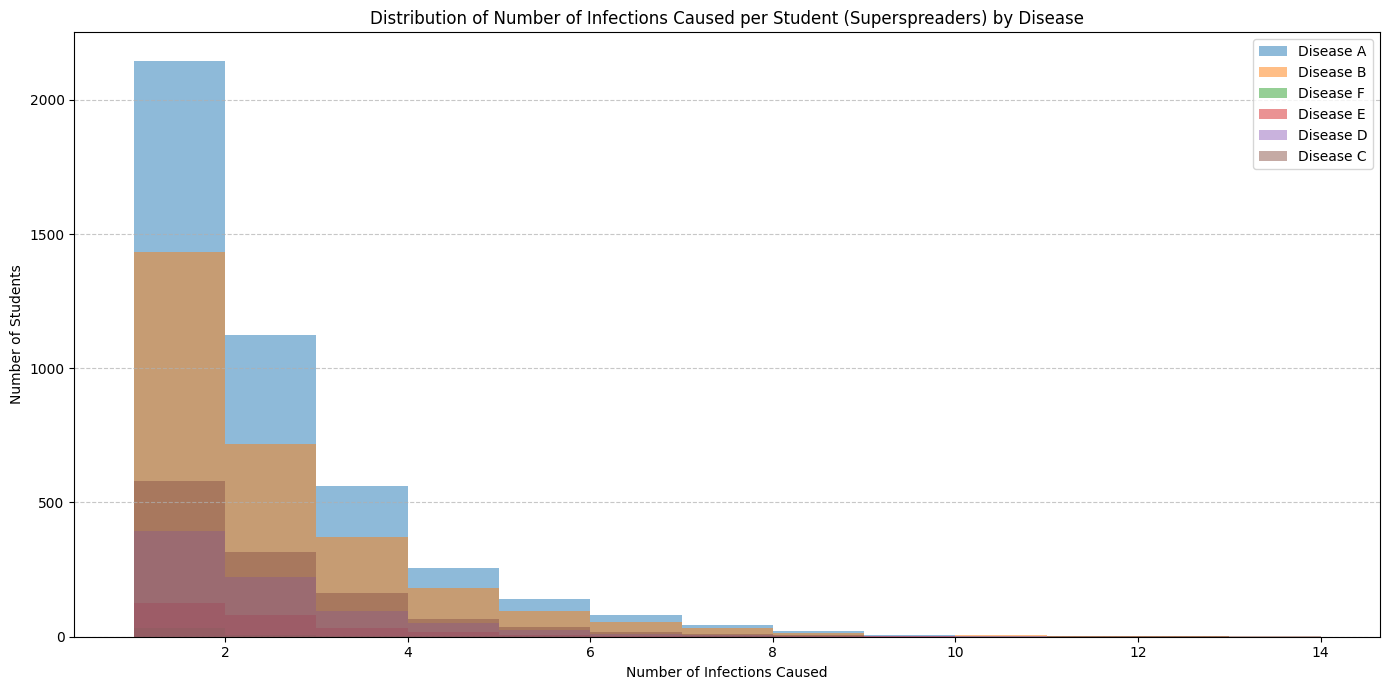

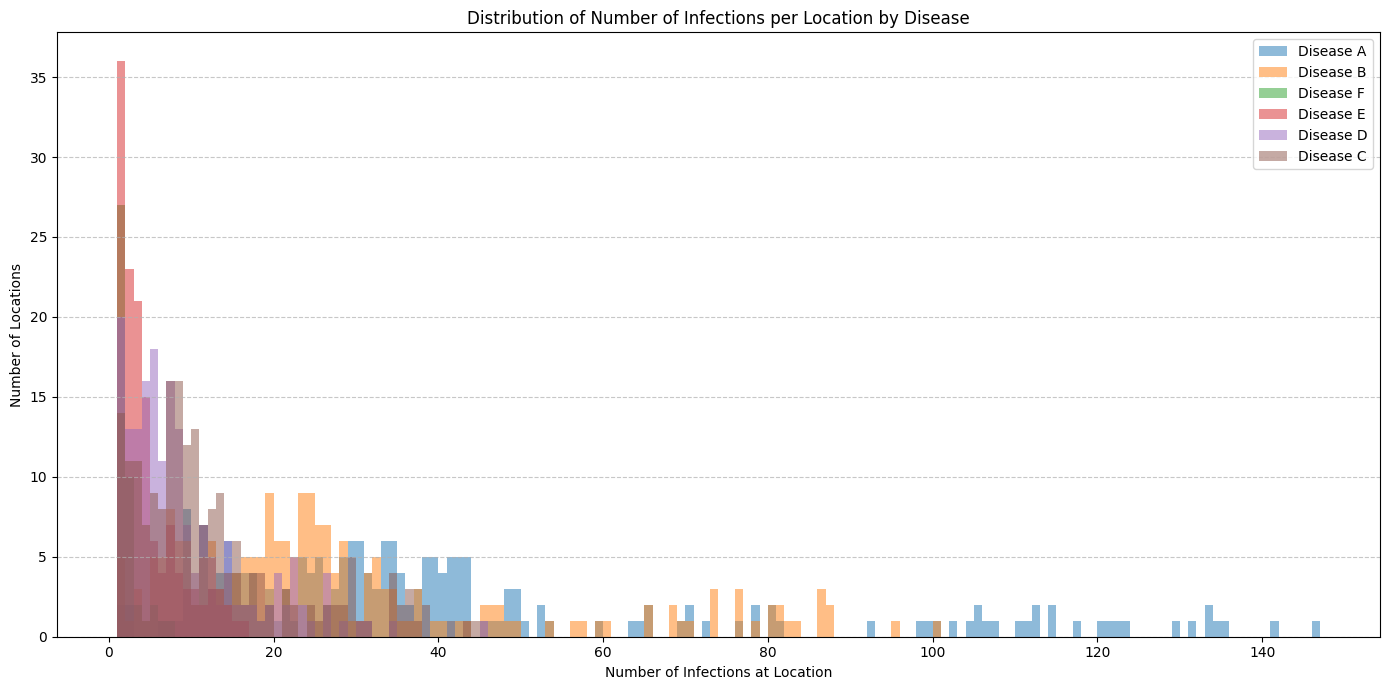


Top 5 superspreaders for Disease <__main__.Disease object at 0x000001F5F0199E80>:
Series([], Name: count, dtype: int64)

Top 5 transmission locations for Disease <__main__.Disease object at 0x000001F5F0199E80>:
Series([], Name: count, dtype: int64)

Top 5 superspreaders for Disease <__main__.Disease object at 0x000001F5AF20DF90>:
Series([], Name: count, dtype: int64)

Top 5 transmission locations for Disease <__main__.Disease object at 0x000001F5AF20DF90>:
Series([], Name: count, dtype: int64)

Top 5 superspreaders for Disease <__main__.Disease object at 0x000001F5F018B390>:
Series([], Name: count, dtype: int64)

Top 5 transmission locations for Disease <__main__.Disease object at 0x000001F5F018B390>:
Series([], Name: count, dtype: int64)

Top 5 superspreaders for Disease <__main__.Disease object at 0x000001F5AF124B00>:
Series([], Name: count, dtype: int64)

Top 5 transmission locations for Disease <__main__.Disease object at 0x000001F5AF124B00>:
Series([], Name: count, dtype: int64)


In [5]:
#PLOTTING SUPER SPREADER AND LOCATION ANALYSIS
# Get unique diseases
diseasess = infection_log['disease'].unique()

# --- 1. Superspreader Analysis: Number of infections caused per student, per disease ---
plt.figure(figsize=(14, 7))
for disease in diseasess:
    counts = infection_log[infection_log['disease'] == disease]['source_student'].value_counts()
    plt.hist(counts, bins=range(1, counts.max()+2), alpha=0.5, label=f'Disease {disease}')
plt.title('Distribution of Number of Infections Caused per Student (Superspreaders) by Disease')
plt.xlabel('Number of Infections Caused')
plt.ylabel('Number of Students')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 2. Location Analysis: Number of infections per location, per disease ---
plt.figure(figsize=(14, 7))
for disease in diseasess:
    loc_counts = infection_log[infection_log['disease'] == disease]['location'].value_counts()
    plt.hist(loc_counts, bins=range(1, loc_counts.max()+2), alpha=0.5, label=f'Disease {disease}')
plt.title('Distribution of Number of Infections per Location by Disease')
plt.xlabel('Number of Infections at Location')
plt.ylabel('Number of Locations')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optionally, print top 5 superspreaders and locations for each disease
for disease in diseases:
    print(f"\nTop 5 superspreaders for Disease {disease}:")
    print(infection_log[infection_log['disease'] == disease]['source_student'].value_counts().head(5))
    print(f"\nTop 5 transmission locations for Disease {disease}:")
    print(infection_log[infection_log['disease'] == disease]['location'].value_counts().head(5))

In [6]:
def analyze_and_plot_sir_combined(filepath):
    """
    Loads simulation data, analyzes infected and recovered counts for all diseases,
    and plots all diseases' infected numbers on one graph and all recovered numbers on another.
    Disease lines are labeled with their transmission rate.
    """
    # --- 1. Load Data ---
    print(f"Loading simulation results from '{filepath}'...")
    try:
        df = pd.read_csv(filepath)
        print("File loaded successfully.")
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        print("Please ensure the file is in the same directory as this notebook or provide the full path.")
        return

    # --- 2. Analyze Infected and Recovered Counts ---
    # Find all disease state columns and sort them chronologically
    disease_cols = sorted(
        [col for col in df.columns if col.startswith('Disease_T_')],
        key=lambda x: int(re.search(r'(\d+)', x).group(1))
    )
    
    if not disease_cols:
        print("Error: No 'Disease_T_...' columns found in the provided file.")
        return

    # Use the Disease objects defined earlier (not overwritten by any other cell)
    # If you get an error here, make sure you have not overwritten 'diseases' elsewhere!
    if isinstance(diseases[0], str):
        raise ValueError("The variable 'diseases' has been overwritten as a list of strings. "
                         "Please restart your kernel and ensure 'diseases' refers to your Disease objects.")

    disease_labels = [d.name for d in diseases]
    transmission_rates = {d.name: d.transmission_rate for d in diseases}
    print(f"Found {len(disease_cols)} time steps to analyze...")

    results = {label: {'infected': [], 'recovered': []} for label in disease_labels}
    hours = []

    for col in disease_cols:
        t = int(re.search(r'(\d+)', col).group(1))
        hours.append(t)
        disease_states = df[col].astype(str).str.zfill(len(disease_labels))
        for i, label in enumerate(disease_labels):
            infected = (disease_states.str[i] == '1').sum()
            recovered = (disease_states.str[i] == '2').sum()
            results[label]['infected'].append(infected)
            results[label]['recovered'].append(recovered)

    # Plot infected numbers
    plt.figure(figsize=(14, 7))
    for label in disease_labels:
        plt.plot(hours, results[label]['infected'], label=f"{label} (β={transmission_rates[label]:.3f})")
    #plt.title('Number of Infected Students Over Time (All Diseases)')
    plt.xlabel('Hour of Simulation', fontsize = 20)
    plt.ylabel('Number of Infected Students', fontsize = 20)
    plt.legend(title='Disease (Transmission Rate)', fontsize = 15)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot recovered numbers
    plt.figure(figsize=(14, 7))
    for label in disease_labels:
        plt.plot(hours, results[label]['recovered'], label=f"{label} (β={transmission_rates[label]:.3f})")
    #plt.title('Number of Recovered Students Over Time (All Diseases)')
    plt.xlabel('Hour of Simulation', fontsize = 20)
    plt.ylabel('Number of Recovered Students', fontsize = 20)
    plt.legend(title='Disease (Transmission Rate)', fontsize = 15)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Loading simulation results from 'Disease_track_completeV2.csv'...
File loaded successfully.
Found 672 time steps to analyze...


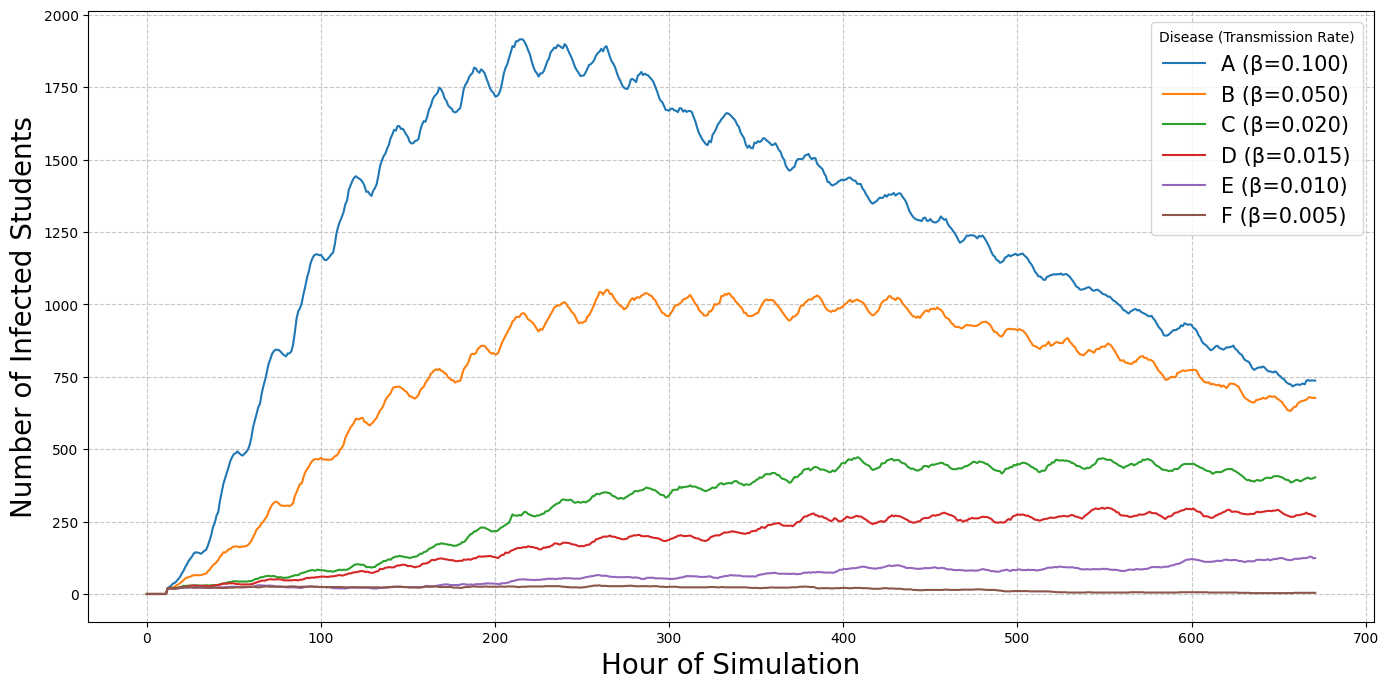

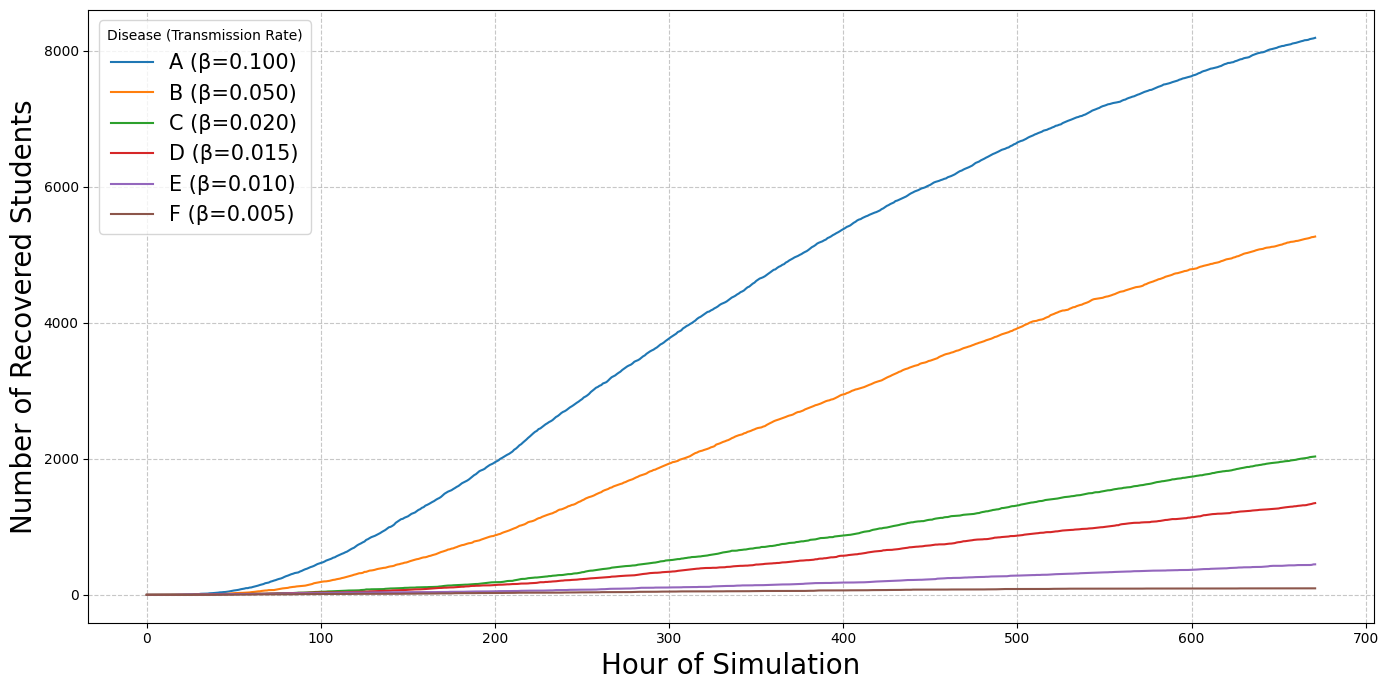

In [7]:
analyze_and_plot_sir_combined(disease_tracker)

Loading simulation results from 'Disease_track_completeV2.csv'...
File loaded successfully.
Found 672 time steps to analyze...
Analysis complete.
Generating plots...


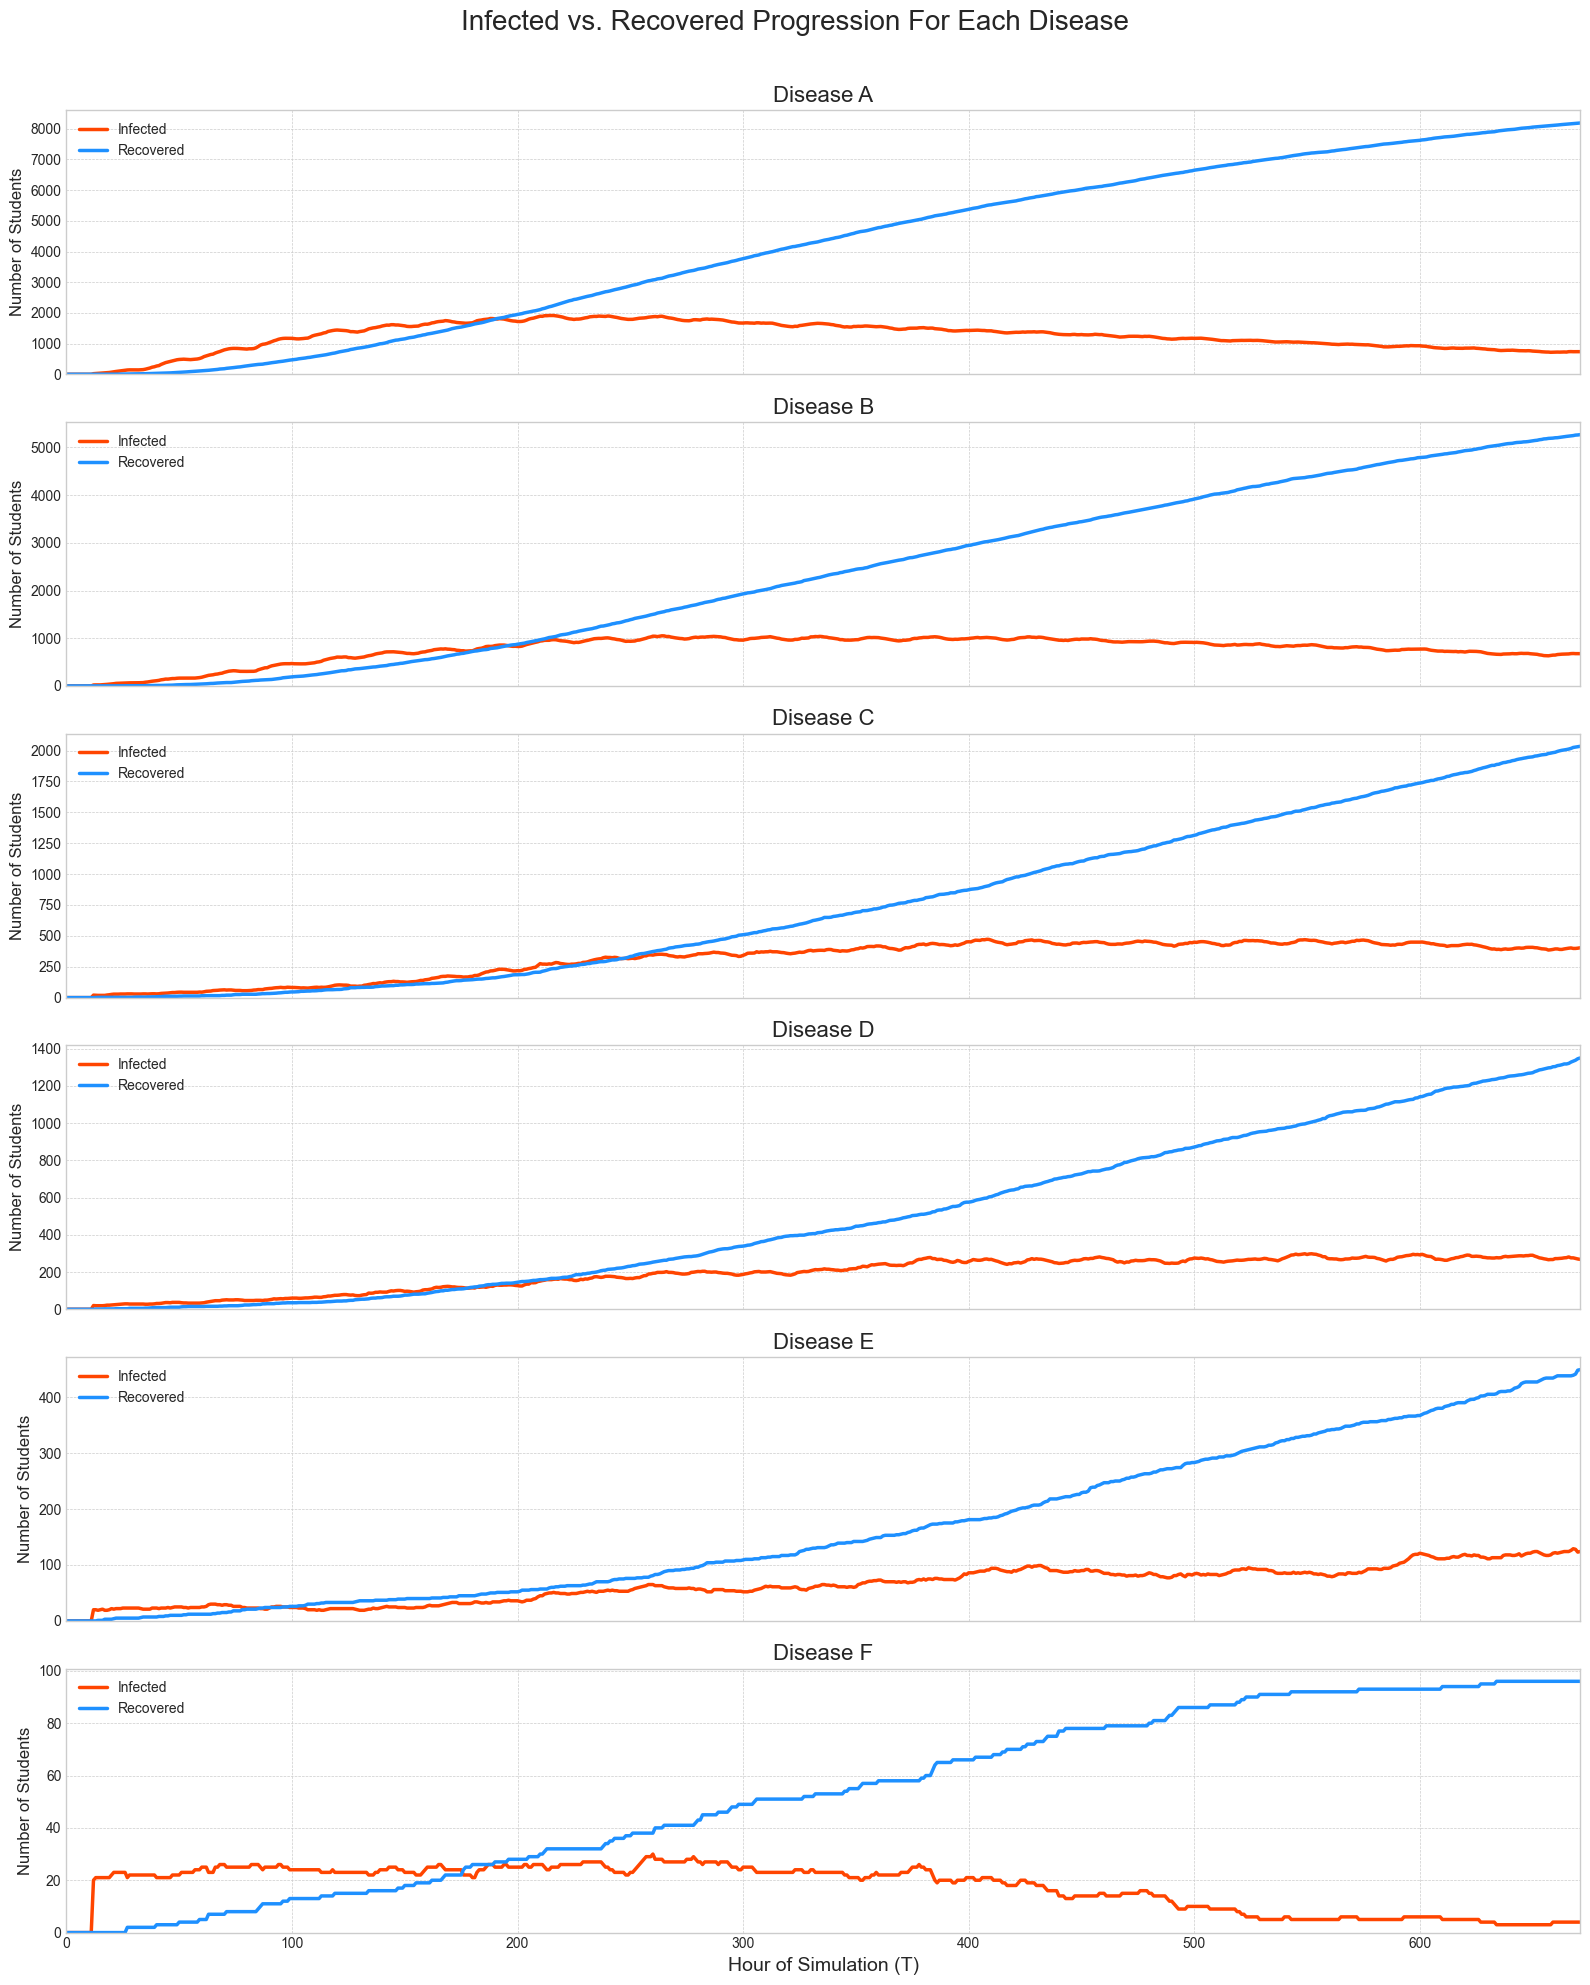

In [8]:
analyze_and_plot_sir_results(disease_tracker)

In [9]:
# Load simulation results and ensure 'Subject' column exists
subjects = df['Subject'].unique()
colleges = df['College'].unique()
disease_labels = [d.name for d in diseases]  # Use your Disease class list

# Find all disease state columns and sort them
disease_cols = sorted([col for col in df.columns if col.startswith('Disease_T_')],
                      key=lambda x: int(re.search(r'(\d+)', x).group(1)))

subject_infection_pct = {disease: pd.DataFrame(index=subjects, columns=[int(re.search(r'(\d+)', col).group(1)) for col in disease_cols])
                         for disease in disease_labels}
college_infection_pct = {disease: pd.DataFrame(index=colleges, columns=[int(re.search(r'(\d+)', col).group(1)) for col in disease_cols])
                         for disease in disease_labels}

for col in disease_cols:
    t = int(re.search(r'(\d+)', col).group(1))
    disease_states = df[col].astype(str).str.zfill(len(disease_labels))
    for i, disease in enumerate(disease_labels):
        df['infected'] = disease_states.str[i] == '1'
        pct_infected = df.groupby('Subject')['infected'].mean() * 100
        subject_infection_pct[disease][t] = pct_infected
        pct_infected = df.groupby('College')['infected'].mean() * 100
        college_infection_pct[disease][t] = pct_infected


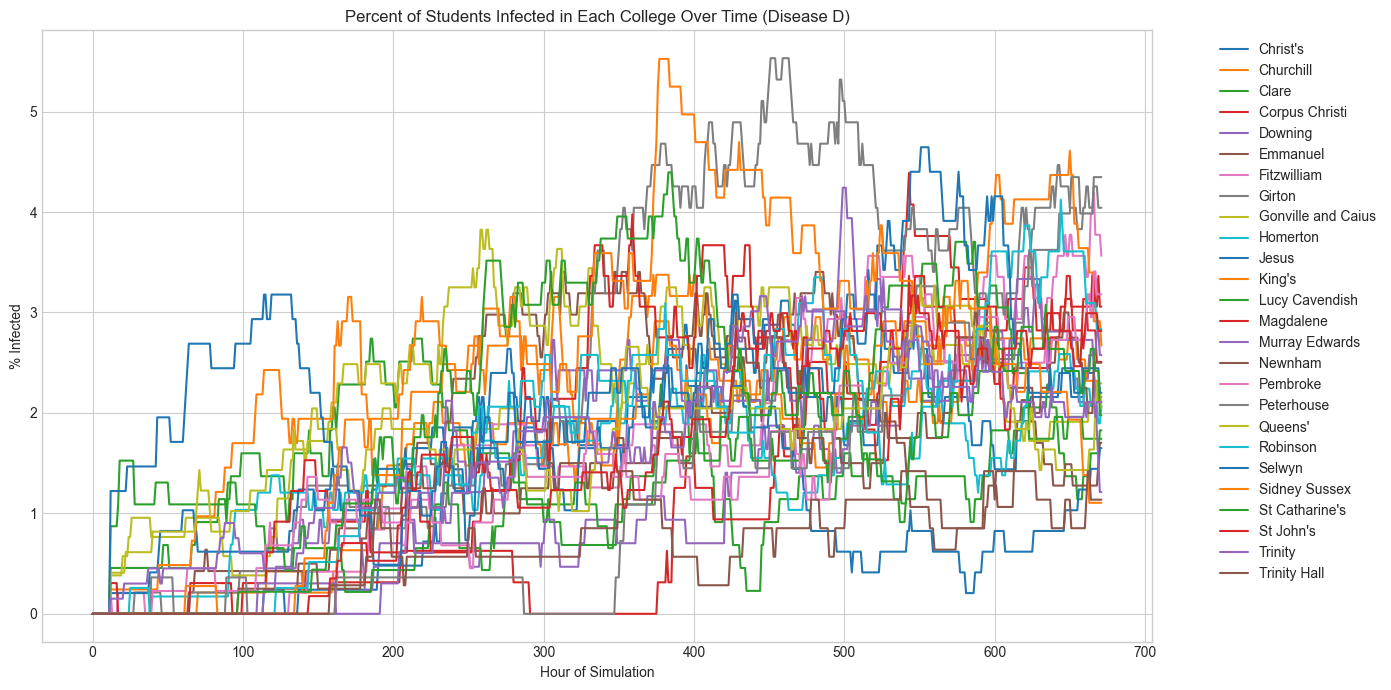

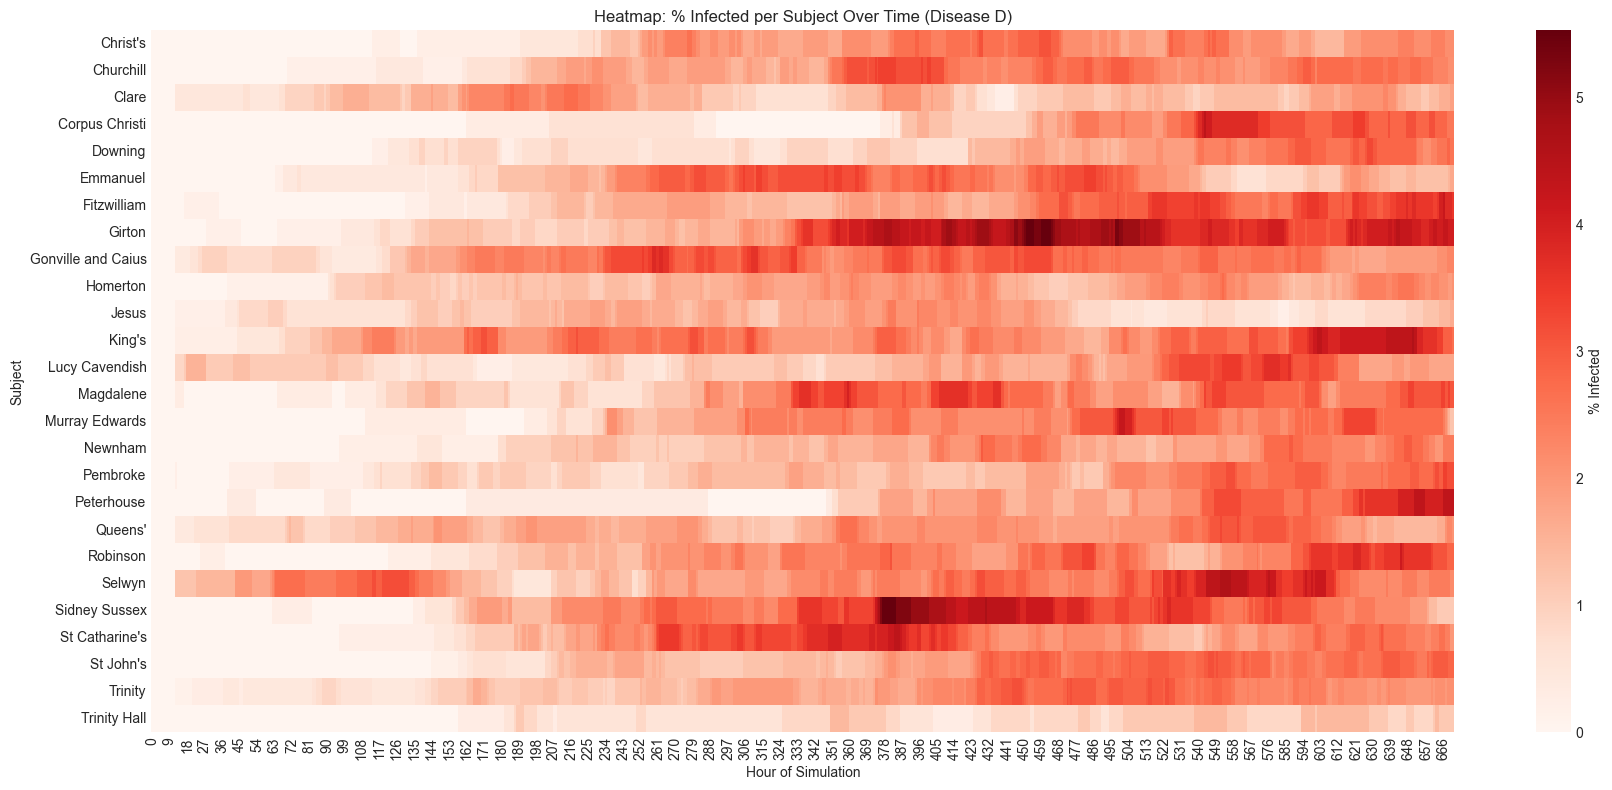

In [10]:
# Load simulation results and ensure 'College' column exists
# Plot % infected for each college over time for one disease (example: Disease A)
letter = 'D'
plt.figure(figsize=(14, 7))
for college in colleges:
    plt.plot(college_infection_pct[letter].columns, college_infection_pct[letter].loc[college], label=college)
plt.title('Percent of Students Infected in Each College Over Time (Disease ' + letter + ')')
plt.xlabel('Hour of Simulation')
plt.ylabel('% Infected')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 8))
sns.heatmap(college_infection_pct[letter].astype(float), cmap='Reds', cbar_kws={'label': '% Infected'})
plt.title('Heatmap: % Infected per Subject Over Time (Disease ' + letter +')')
plt.xlabel('Hour of Simulation')
plt.ylabel('Subject')
plt.tight_layout()
plt.show()

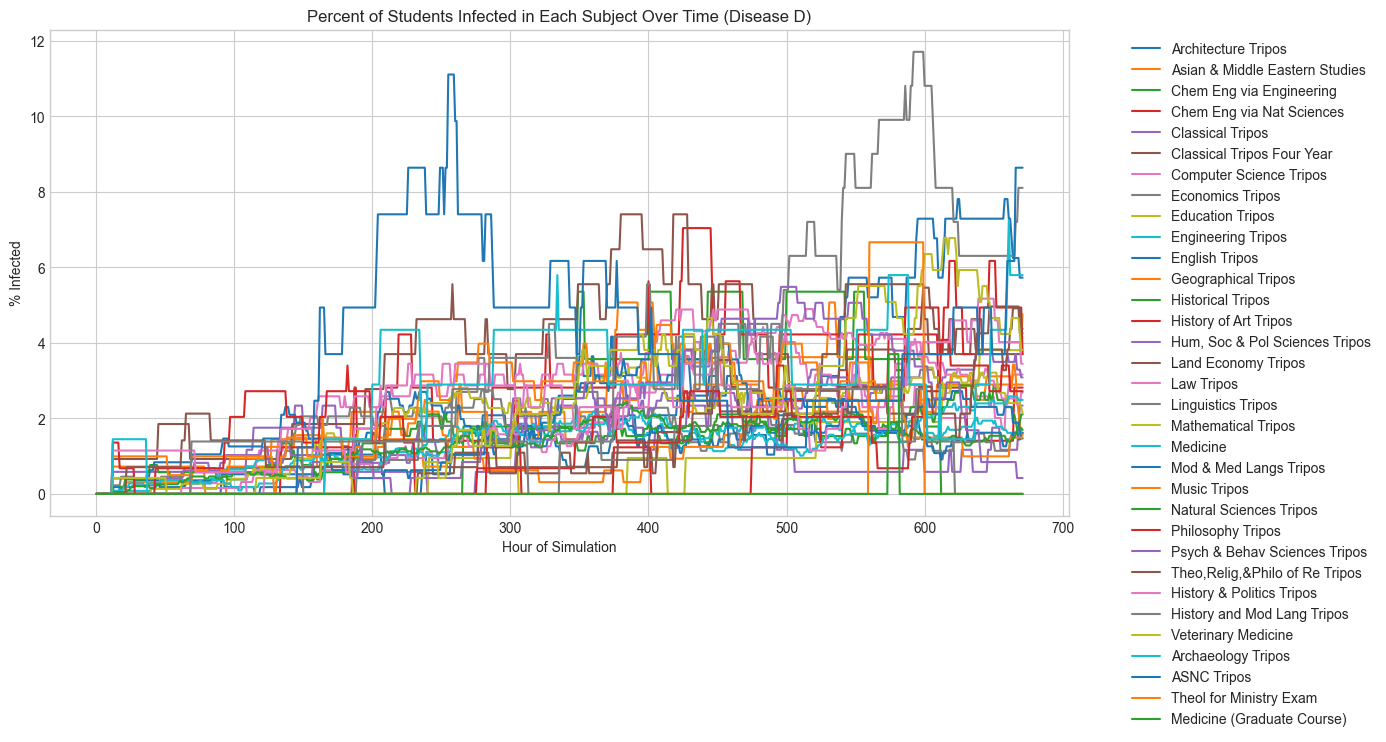

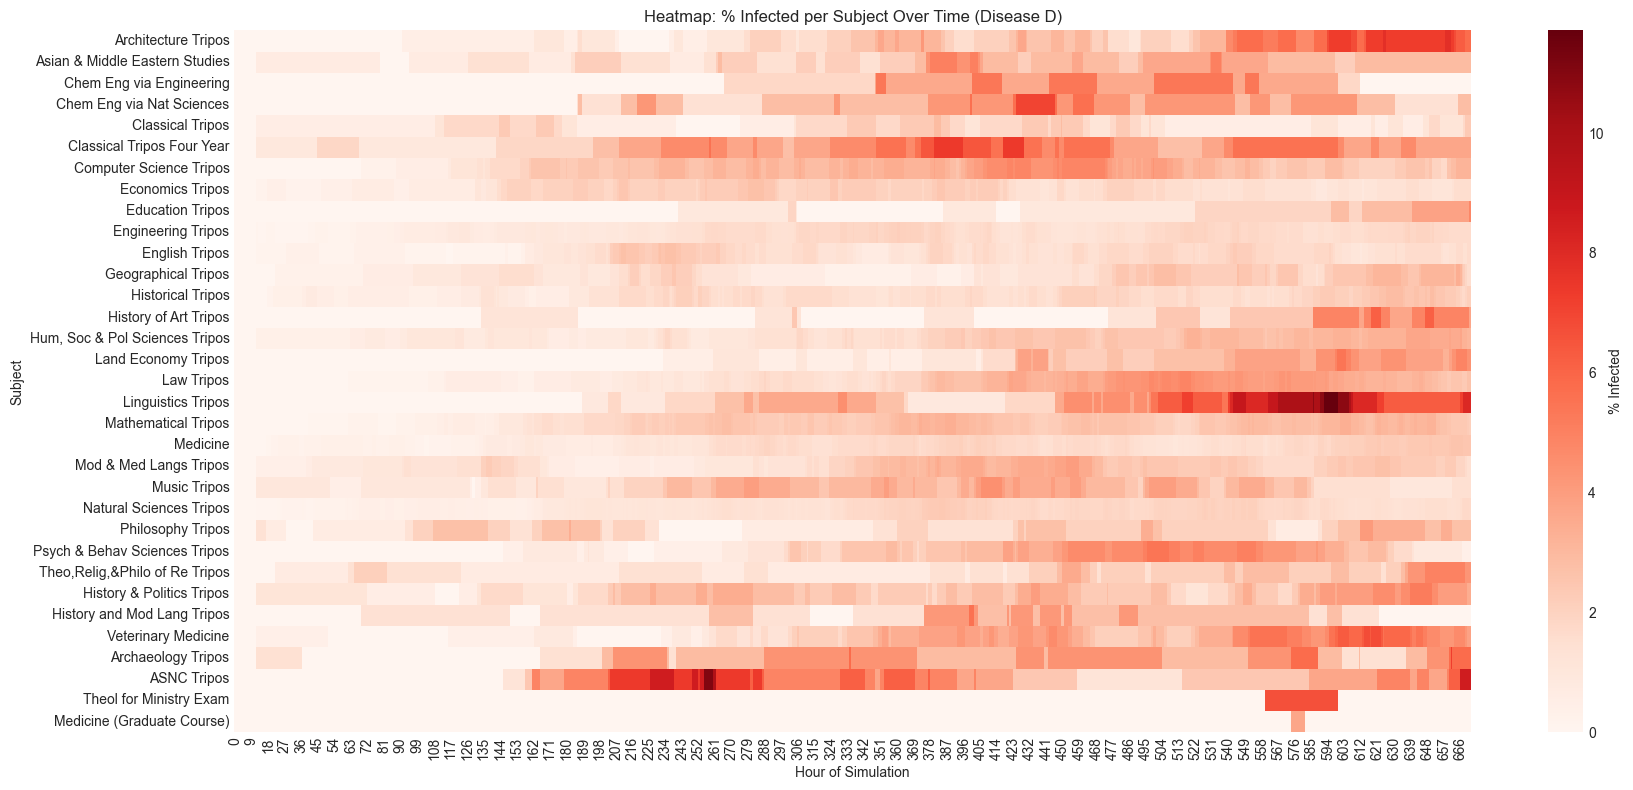

In [11]:

letter = 'D'
# Plot % infected for each subject over time for one disease (example: Disease A)
plt.figure(figsize=(14, 7))
for subject in subjects:
    plt.plot(subject_infection_pct[letter].columns, subject_infection_pct[letter].loc[subject], label=subject)
plt.title('Percent of Students Infected in Each Subject Over Time (Disease '+ letter + ')')
plt.xlabel('Hour of Simulation')
plt.ylabel('% Infected')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- HEATMAP VERSION for one disease (example: Disease A) ---
import seaborn as sns

plt.figure(figsize=(18, 8))
sns.heatmap(subject_infection_pct[letter].astype(float), cmap='Reds', cbar_kws={'label': '% Infected'})
plt.title('Heatmap: % Infected per Subject Over Time (Disease '+ letter + ')')
plt.xlabel('Hour of Simulation')
plt.ylabel('Subject')
plt.tight_layout()
plt.show()

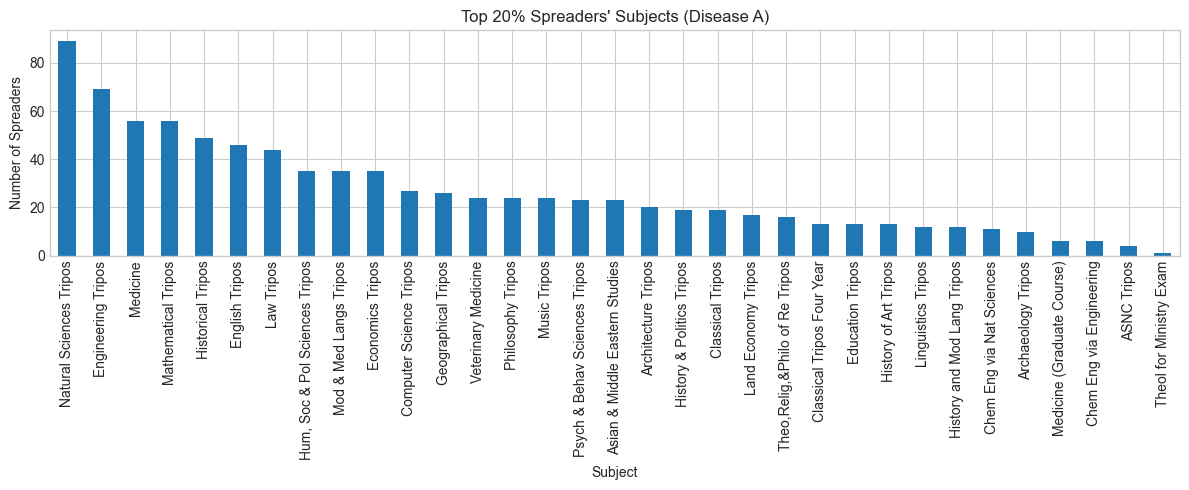

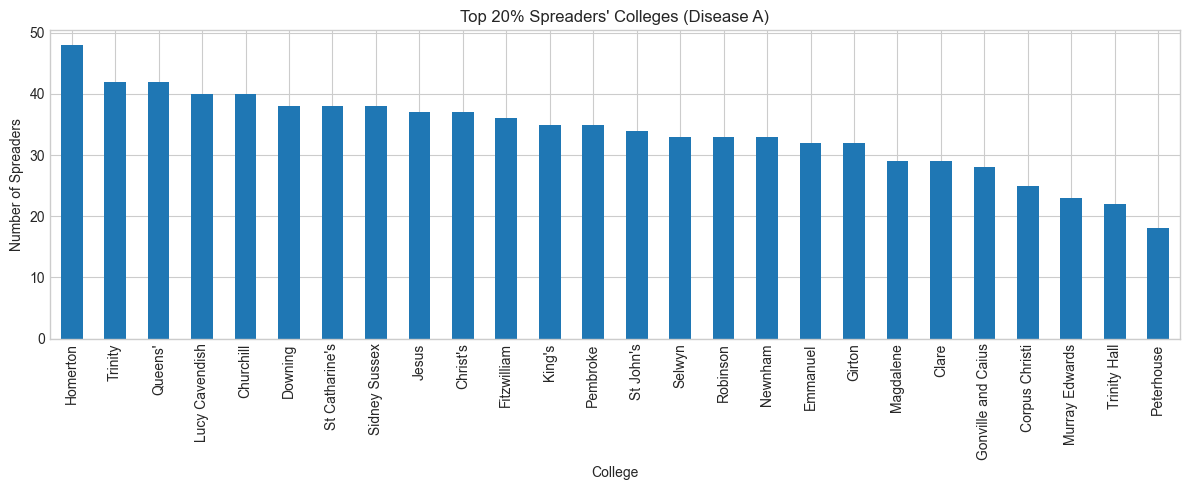

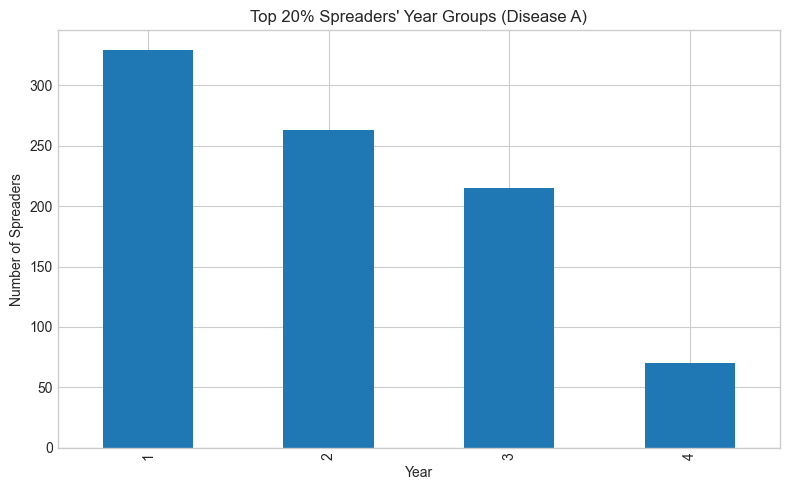

In [12]:
# Identify top 20% spreaders for disease 'A'
spread_counts = infection_log[infection_log['disease'] == 'A']['source_student'].value_counts()
top_n = int(np.ceil(0.2 * len(spread_counts)))
top_spreaders = spread_counts.head(top_n).index

# Get their info from df
top_spreader_info = df[df['StudentID'].isin(top_spreaders)]

# Plot subject distribution
plt.figure(figsize=(12, 5))
top_spreader_info['Subject'].value_counts().plot(kind='bar')
plt.title("Top 20% Spreaders' Subjects (Disease A)")
plt.xlabel('Subject')
plt.ylabel('Number of Spreaders')
plt.tight_layout()
plt.show()

# Plot college distribution
plt.figure(figsize=(12, 5))
top_spreader_info['College'].value_counts().plot(kind='bar')
plt.title("Top 20% Spreaders' Colleges (Disease A)")
plt.xlabel('College')
plt.ylabel('Number of Spreaders')
plt.tight_layout()
plt.show()

# Plot year group distribution
plt.figure(figsize=(8, 5))
top_spreader_info['Year'].value_counts().sort_index().plot(kind='bar')
plt.title("Top 20% Spreaders' Year Groups (Disease A)")
plt.xlabel('Year')
plt.ylabel('Number of Spreaders')
plt.tight_layout()
plt.show()

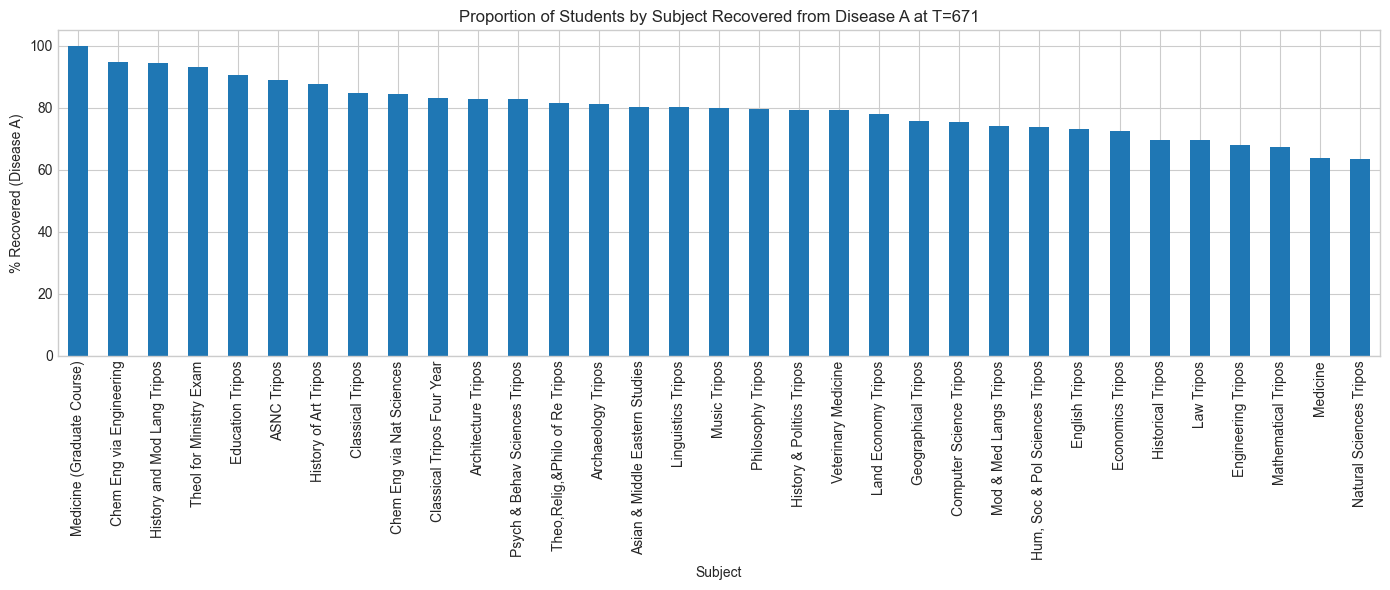

In [13]:
# Calculate the proportion of students by subject who have recovered from disease A at T=671
# '2' means recovered in the disease state string for disease A (index 0)
recovered_mask = disease_states.str[0] == '2'
recovered_by_subject = df[recovered_mask].groupby('Subject').size()
total_by_subject = df.groupby('Subject').size()
recovered_pct = (recovered_by_subject / total_by_subject * 100).sort_values(ascending=False)

plt.figure(figsize=(14, 6))
recovered_pct.plot(kind='bar')
plt.ylabel('% Recovered (Disease A)')
plt.xlabel('Subject')
plt.title('Proportion of Students by Subject Recovered from Disease A at T=671')
plt.tight_layout()
plt.show()

Loading simulation results from 'Disease_track_completeV2.csv'...
File loaded successfully.
Found 672 time steps to analyze...
Analysis complete.
Generating plots...


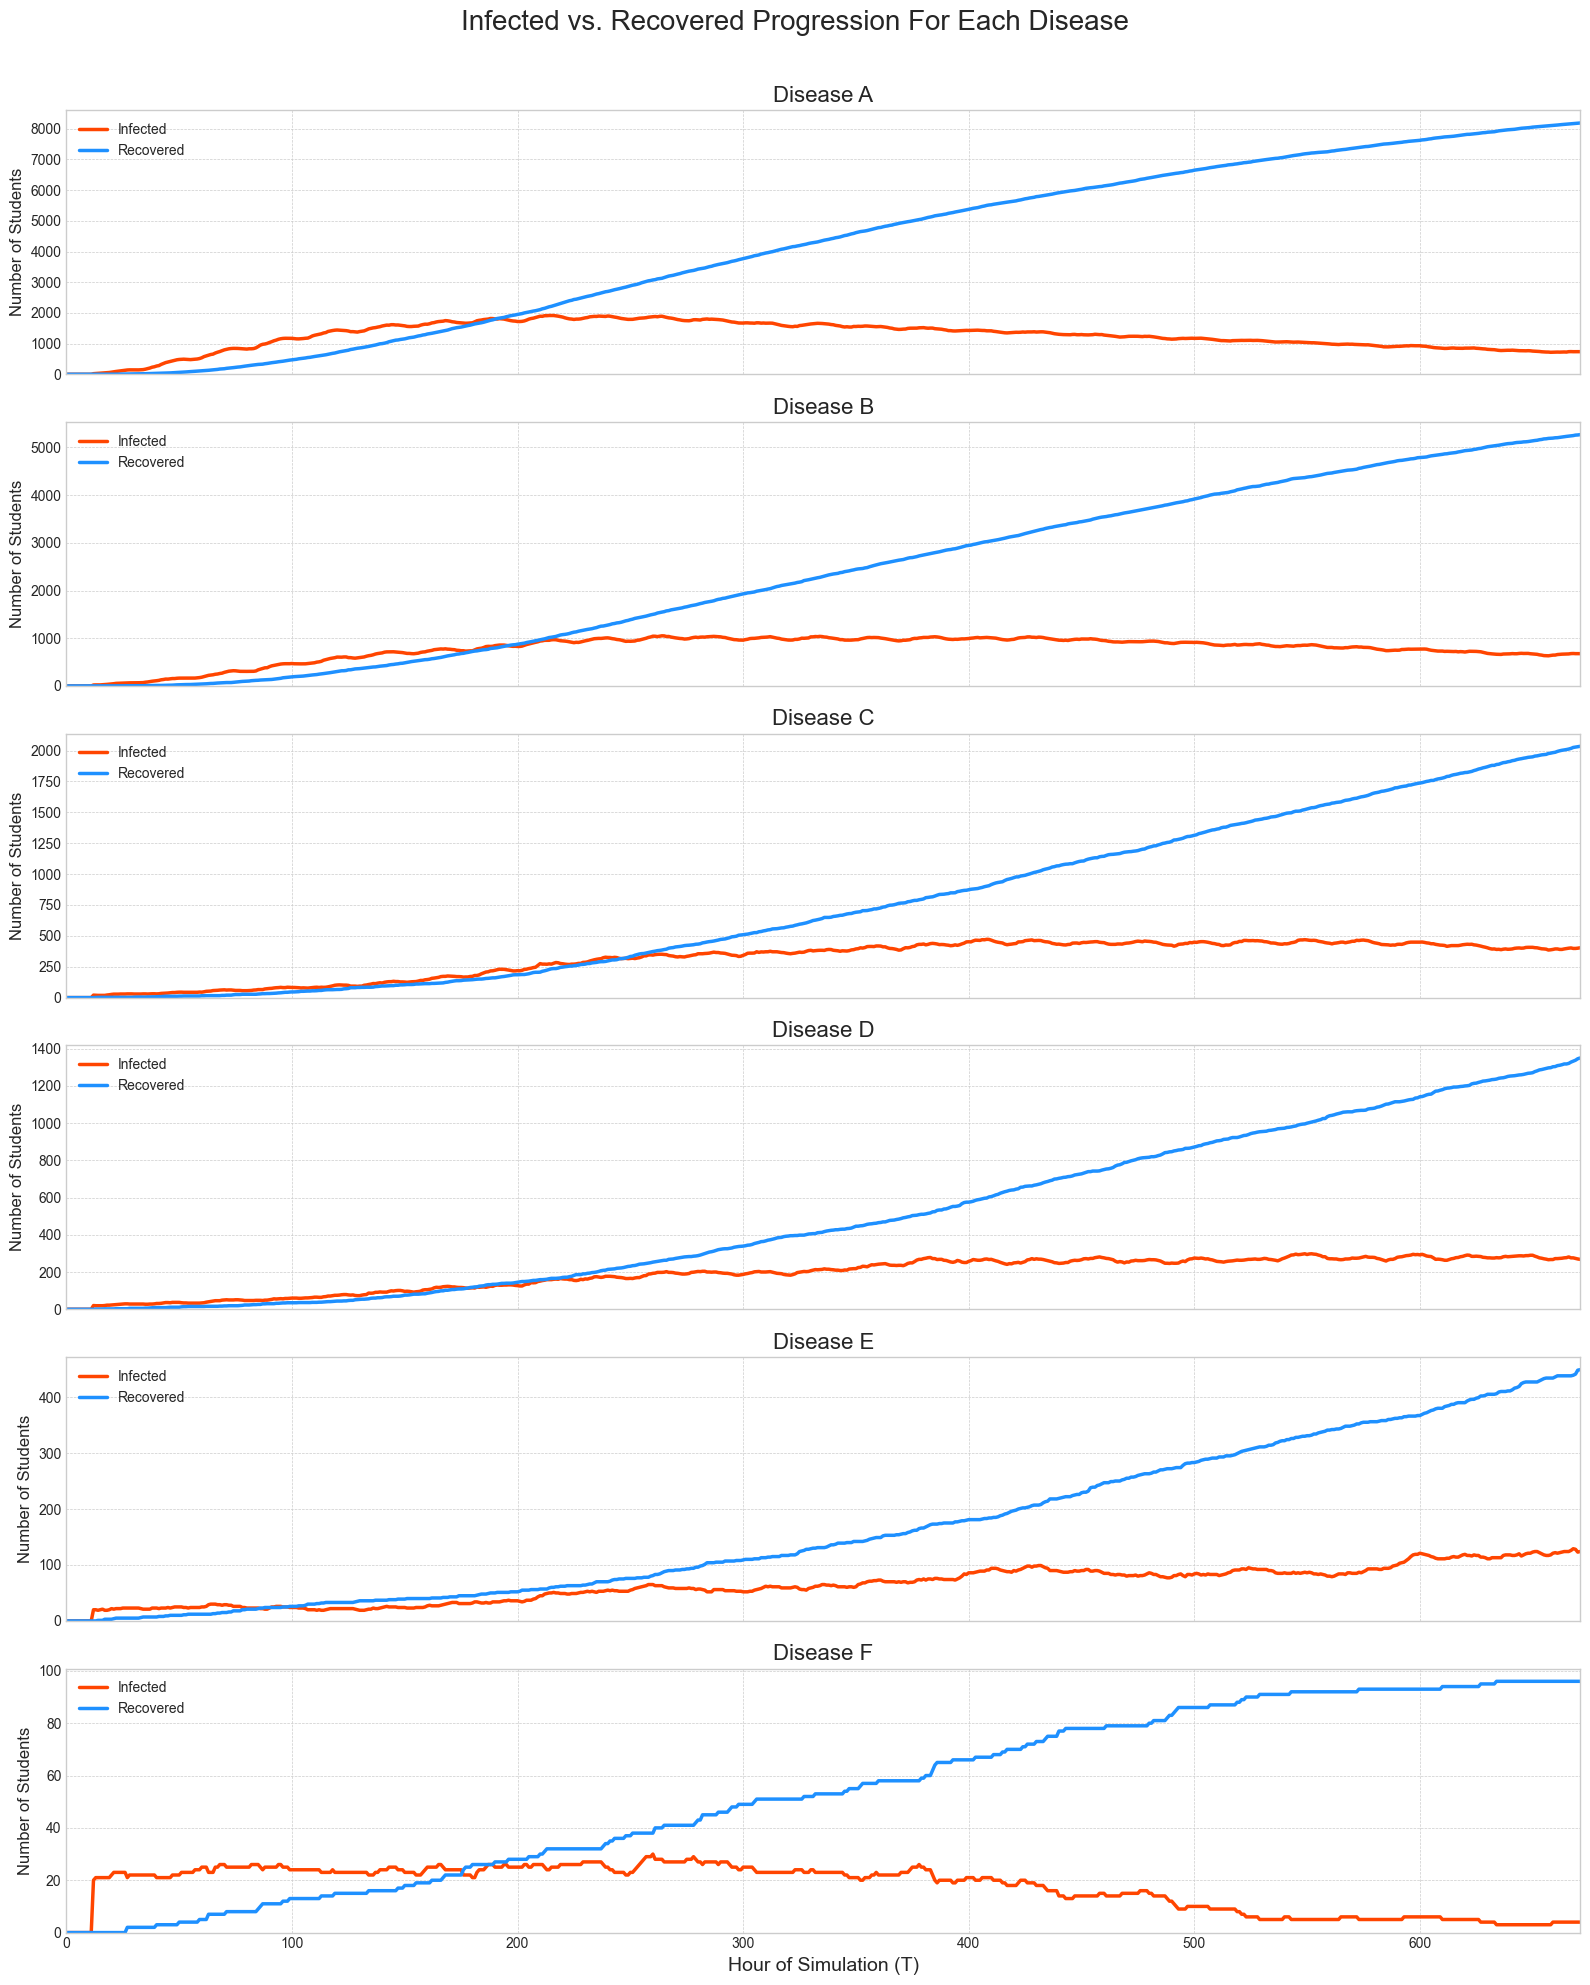

In [14]:
analyze_and_plot_sir_results(disease_tracker)

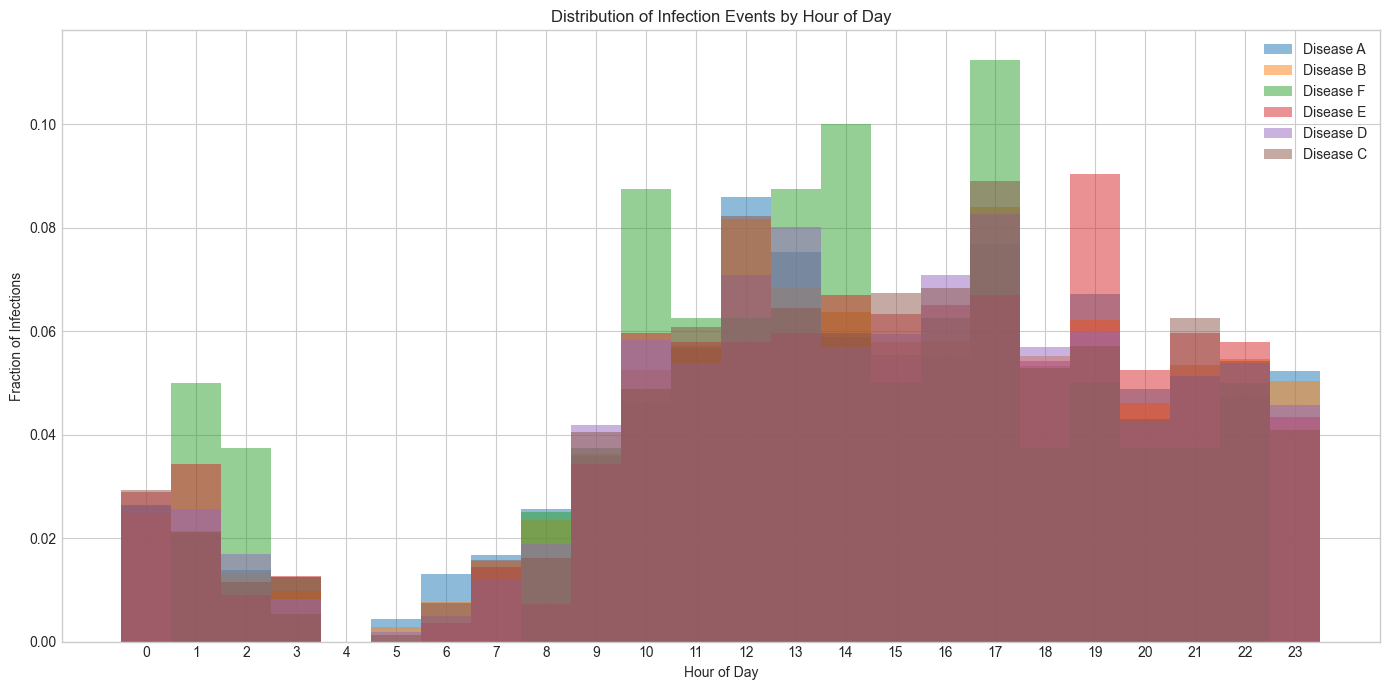

In [15]:
# --- Infection Timing Analysis: When During the Day Do Infections Occur? ---

# Ensure infection_log is loaded
infection_log = pd.read_csv('infection_events_log.csv')

# Add 'HourOfDay' column (0=midnight, 23=11pm)
infection_log['HourOfDay'] = infection_log['time'] % 24

# Plot histogram of infection events by hour of day, for each disease
plt.figure(figsize=(14, 7))
for disease in infection_log['disease'].unique():
    hours = infection_log[infection_log['disease'] == disease]['HourOfDay']
    plt.hist(hours, bins=np.arange(25)-0.5, alpha=0.5, label=f'Disease {disease}', density=True)
plt.xlabel('Hour of Day')
plt.ylabel('Fraction of Infections')
plt.title('Distribution of Infection Events by Hour of Day')
plt.xticks(range(24))
plt.legend()
plt.tight_layout()
plt.show()